In [1]:
import pandas as pd
from sqlalchemy import create_engine, text
import os 
import cryptography
import pymysql
import numpy as np
import datetime as dt 
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import sklearn

In [3]:
project_path = os.getcwd()
doc_path = os.path.join(project_path, "dataset")
fichiers = os.listdir(doc_path)

cutsomers = pd.read_csv(os.path.join(doc_path, fichiers[0]))
geolocalisation = pd.read_csv(os.path.join(doc_path, fichiers[1]))
orders_dataset = pd.read_csv(os.path.join(doc_path, fichiers[2]))
order_items = pd.read_csv(os.path.join(doc_path, fichiers[3]))
order_payment = pd.read_csv(os.path.join(doc_path, fichiers[4]))
orders_reviews = pd.read_csv(os.path.join(doc_path, fichiers[5]))
products = pd.read_csv(os.path.join(doc_path, fichiers[6]))
sellers = pd.read_csv(os.path.join(doc_path, fichiers[7]))
product_category_name_transalation = pd.read_csv(os.path.join(doc_path, fichiers[8]))

# Data Preprocessing 

In [4]:
customer_orders = pd.merge(orders_dataset, cutsomers, on = "customer_id", how = "inner")
customer_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [5]:
customer_orders.groupby("customer_unique_id").agg({"order_id": "count"}).sort_values(by = "order_id", ascending = False).head(100)

,order_id
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,17
3e43e6105506432c953e165fb2acf44c,9
6469f99c1f9dfae7733b25662e7f1782,7
ca77025e7201e3b30c44b472ff346268,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7
...,...
51d91326ffc0688da14a001de38c264b,3
c6df3869c263531ebd51f0454a353605,3
ef0103e9602d12594d19c2b666219bc1,3


In [6]:
only_unique_customers = customer_orders[customer_orders.groupby('customer_unique_id').customer_unique_id.transform('count')>1].copy() 
display(only_unique_customers.head())

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
15,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f,74820,goiania,GO
16,403b97836b0c04a622354cf531062e5f,738b086814c6fcc74b8cc583f8516ee3,delivered,2018-01-02 19:00:43,2018-01-02 19:09:04,2018-01-03 18:19:09,2018-01-20 01:38:59,2018-02-06 00:00:00,6e26bbeaa107ec34112c64e1ee31c0f5,21381,rio de janeiro,RJ
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP
46,d17dc4a904426827ca80f2ccb3a6be56,569cf68214806a39acc0f39344aea67f,delivered,2017-05-14 20:28:25,2017-05-14 20:42:45,2017-05-16 08:17:46,2017-05-25 09:14:31,2017-06-12 00:00:00,c2551ea089b7ebbc67a2ea8757152514,44380,cruz das almas,BA


In [7]:
only_unique_customers.groupby("customer_unique_id").agg({"order_id": "count"}).sort_values(by = "order_id", ascending = False).head(100)

,order_id
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,17
3e43e6105506432c953e165fb2acf44c,9
1b6c7548a2a1f9037c1fd3ddfed95f33,7
6469f99c1f9dfae7733b25662e7f1782,7
ca77025e7201e3b30c44b472ff346268,7
...,...
e9b87dccd9c326a3325385087eb0150c,3
ae20947231d4d44dde1680a7ab14d90a,3
93360190b9375a40b65720ee99387a4a,3


In [8]:
def get_month(x): return dt.datetime(x.year, x.month, 1)

In [9]:
only_unique_customers['order_purchase_timestamp'] = pd.to_datetime(only_unique_customers['order_purchase_timestamp'])

In [10]:
only_unique_customers['InvoiceDate'] = [d.date() for d in only_unique_customers["order_purchase_timestamp"]]

In [11]:
print('min:{}; Max:{}'.format(min(only_unique_customers['InvoiceDate']), max(only_unique_customers['InvoiceDate'])))

min:2016-10-03; Max:2018-10-16


In [12]:
snapshot_date = max(only_unique_customers['InvoiceDate']) + dt.timedelta(days=1)

In [13]:
order_customer_paiement = pd.merge(only_unique_customers, order_payment,  on = "order_id", how = "inner")

In [64]:
order_customer_paiement_review = pd.merge(order_customer_paiement, orders_reviews,  on = "order_id", how = "inner")

In [65]:
order_customer_paiement_review.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,dcb36b511fcac050b97cd5c05de84dc3,3b6828a50ffe546942b7a473d70ac0fc,delivered,2018-06-07 19:03:12,2018-06-12 23:31:02,2018-06-11 14:54:00,2018-06-21 15:34:32,2018-07-04 00:00:00,ccafc1c3f270410521c3c6f3b249870f,74820,...,1,credit_card,10,146.45,5a8608437f4b52bec5cd143f37258b5e,5,Nota dez,Obrigado pela atenção. Lojas lannister perfeit...,2018-07-03 00:00:00,2018-07-03 15:10:07
4,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259,13215,...,1,boleto,1,22.36,5853e27c64b89e222c5e4edf78bec3d4,1,NaN,NaN,2018-07-01 00:00:00,2018-07-11 20:41:18


## Get RFM values

In [76]:
data = order_customer_paiement_review.groupby(['customer_unique_id']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,"order_id": "count", "payment_value": "sum", "review_score": "mean", "review_comment_message": lambda x: np.mean(len(x)), "payment_installments": "mean"})

In [77]:
data.head()

,InvoiceDate,order_id,payment_value,review_score,review_comment_message,payment_installments
customer_unique_id,,,,,,
00172711b30d52eea8b313a7f2cced02,65,2,244.14,4.000000,2.0,1.5
004288347e5e88a27ded2bb23747066c,276,2,354.37,5.000000,2.0,2.0
004b45ec5c64187465168251cd1c9c2f,144,2,147.72,3.000000,2.0,1.0
0058f300f57d7b93c477a131a59b36c3,209,3,175.58,3.666667,3.0,1.0
00a39521eb40f7012db50455bf083460,136,2,123.25,4.000000,2.0,1.0


In [79]:
data.rename(columns = {'InvoiceDate': 'Recency', 'order_id': 'Frequency', 'payment_value': 'MonetaryValue'}, inplace = True)

In [80]:
data.head()

,Recency,Frequency,MonetaryValue,review_score,review_comment_message,payment_installments
customer_unique_id,,,,,,
00172711b30d52eea8b313a7f2cced02,65,2,244.14,4.000000,2.0,1.5
004288347e5e88a27ded2bb23747066c,276,2,354.37,5.000000,2.0,2.0
004b45ec5c64187465168251cd1c9c2f,144,2,147.72,3.000000,2.0,1.0
0058f300f57d7b93c477a131a59b36c3,209,3,175.58,3.666667,3.0,1.0
00a39521eb40f7012db50455bf083460,136,2,123.25,4.000000,2.0,1.0


In [81]:
r_labels = [4,3,2,1]
f_labels = [1,2,3,4]
m_labels = [1,2,3,4]

In [82]:
r_quartiles = pd.qcut(data['Recency'], q=4, labels=r_labels, duplicates='drop')


In [83]:
f_quartiles = pd.qcut(data.Frequency.rank(method='first'), 4, labels=f_labels)
print(f_quartiles)

customer_unique_id
00172711b30d52eea8b313a7f2cced02    1
004288347e5e88a27ded2bb23747066c    1
004b45ec5c64187465168251cd1c9c2f    1
0058f300f57d7b93c477a131a59b36c3    4
00a39521eb40f7012db50455bf083460    1
                                   ..
ff36be26206fffe1eb37afd54c70e18b    4
ff44401d0d8f5b9c54a47374eb48c1b8    4
ff8892f7c26aa0446da53d01b18df463    4
ff922bdd6bafcdf99cb90d7f39cea5b3    4
ffe254cc039740e17dd15a5305035928    4
Name: Frequency, Length: 2988, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]


In [84]:
m_quartiles = pd.qcut(data['MonetaryValue'], q=4, labels=m_labels)

In [85]:
data = data.assign(R = r_quartiles.values, F = f_quartiles.values, M = m_quartiles.values)

In [86]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])


In [87]:
data['RFM_segment'] = data.apply(join_rfm, axis=1)
data["RFM_score"] = data[["R", "F", "M"]].sum(axis=1)
data.head()

,Recency,Frequency,MonetaryValue,review_score,review_comment_message,payment_installments,R,F,M,RFM_segment,RFM_score
customer_unique_id,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,65,2,244.14,4.000000,2.0,1.5,4,1,3,4.01.03.0,8
004288347e5e88a27ded2bb23747066c,276,2,354.37,5.000000,2.0,2.0,2,1,3,2.01.03.0,6
004b45ec5c64187465168251cd1c9c2f,144,2,147.72,3.000000,2.0,1.0,4,1,1,4.01.01.0,6
0058f300f57d7b93c477a131a59b36c3,209,3,175.58,3.666667,3.0,1.0,3,4,2,3.04.02.0,9
00a39521eb40f7012db50455bf083460,136,2,123.25,4.000000,2.0,1.0,4,1,1,4.01.01.0,6


In [88]:
data.groupby('RFM_score').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_score                                      
3           475.6       1.9         101.1    51
4           411.5       1.9         127.5   145
5           359.8       2.0         161.7   303
6           319.7       2.1         213.7   480
7           274.2       2.3         260.0   525
8           249.6       2.4         348.7   530
9           218.2       2.6         432.6   453
10          186.4       2.7         540.3   277
11          151.4       3.2         581.2   159
12           95.3       3.9         938.6    65

In [89]:
def segment_me(df):
    if df['RFM_score'] >= 9:
        return 'Gold'
    elif ((df['RFM_score'] >= 8) and (df['RFM_score'] < 9)):
        return 'Silver'
    else:
        return 'Bronze'


In [160]:
data['General_Segment'] = data.apply(segment_me, axis=1)
data.groupby('General_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze              5.7       0.7           5.1  1504
Gold                5.1       1.0           6.0   954
Silver              5.4       0.8           5.6   530

In [167]:
RFM = data[['Recency', 'Frequency', 'MonetaryValue']]
data_predict = data[['Recency', 'Frequency', 'MonetaryValue', 'review_score', 'review_comment_message', 'payment_installments']]


## Change variables for more symetrie and centering and scaling

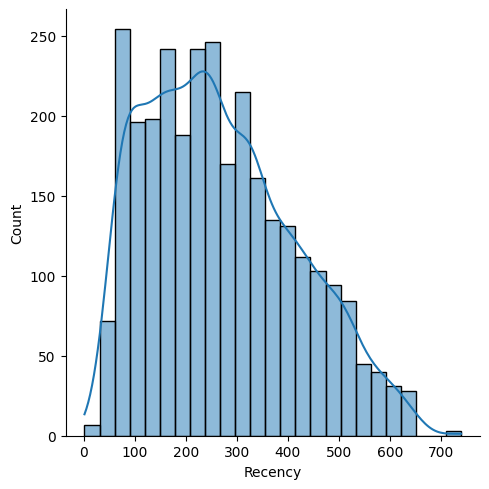

In [210]:
sns.displot(data['Recency'], kde=True)
plt.show()

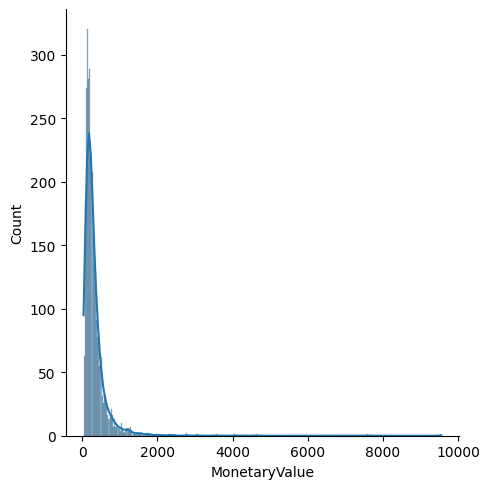

In [211]:
sns.displot(data['MonetaryValue'], kde=True)
plt.show()

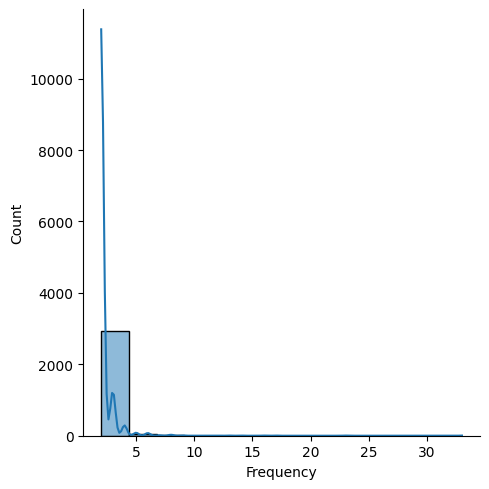

In [212]:
sns.displot(data['Frequency'], kde=True)
plt.show()

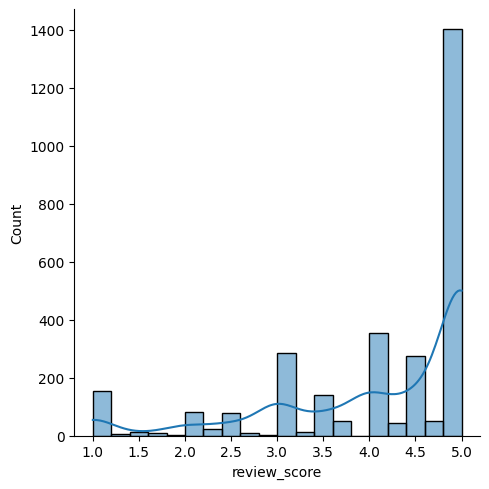

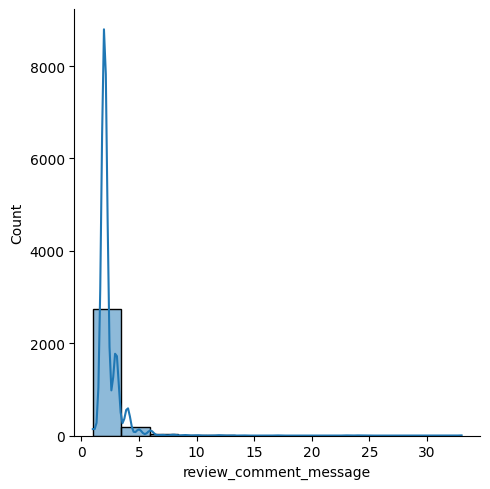

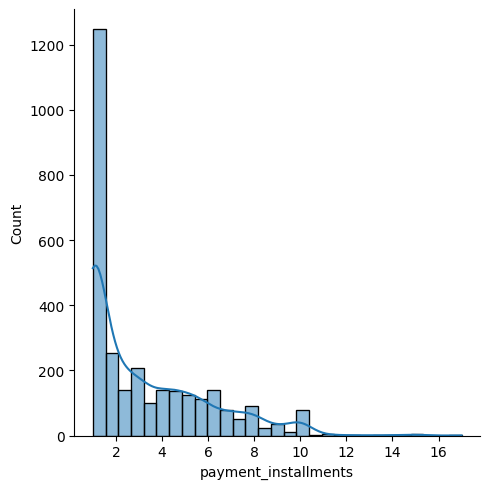

In [93]:
sns.displot(data['review_score'], kde=True)
sns.displot(data['review_comment_message'], kde=True)
sns.displot(data['payment_installments'], kde=True)


In [94]:
#unskew data
frequency_log = np.log(data['Frequency'])
monetary_log = np.log(data['MonetaryValue'])
recency_log = np.log(data['Recency'])
review_score_log = np.log(data['review_score'])
review_message_log = np.log(data['review_comment_message'])
payment_installments_log = np.log(data['payment_installments'])


In [95]:
data['Frequency'] = frequency_log
data['MonetaryValue'] = monetary_log
data['Recency'] = recency_log
data['review_score'] = review_score_log
data['review_comment_message'] = review_message_log
data['payment_installments'] = payment_installments_log

In [98]:
data_RFM = data[['Recency', 'Frequency', 'MonetaryValue', 'RFM_score', 'payment_installments', 'review_score','review_comment_message', 'General_Segment']]
RFM = data_RFM[['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message']]


In [99]:
from sklearn.preprocessing import StandardScaler

#center and scale data
scaler = StandardScaler()
scaler.fit(RFM)

#store for clustering
data_scaled = scaler.transform(RFM)
print('mean:', data_scaled.mean(axis=0).round(2))
print('std:', data_scaled.std(axis=0).round(2))

mean: [-0.  0.  0.  0. -0.  0.]
std: [1. 1. 1. 1. 1. 1.]


# Started clustering experiments

In [105]:
mlflow.tracking.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Eclient segmentation")



2023/04/08 22:12:36 INFO mlflow.tracking.fluent: Experiment with name 'Eclient segmentation' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/348296955867739973', creation_time=1680984756996, experiment_id='348296955867739973', last_update_time=1680984756996, lifecycle_stage='active', name='Eclient segmentation', tags={}>

In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    RFM["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center


c:\Users\litle\repos\eclient_segmentation\eclientvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\litle\AppData\Local\Temp\ipykernel_54940\361126633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFM["clusters"] = kmeans.labels_
c:\Users\litle\repos\eclient_segmentation\eclientvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\litle\AppData\Local\Temp\ipykernel_54940\361126633.py:7: SettingWithCopy

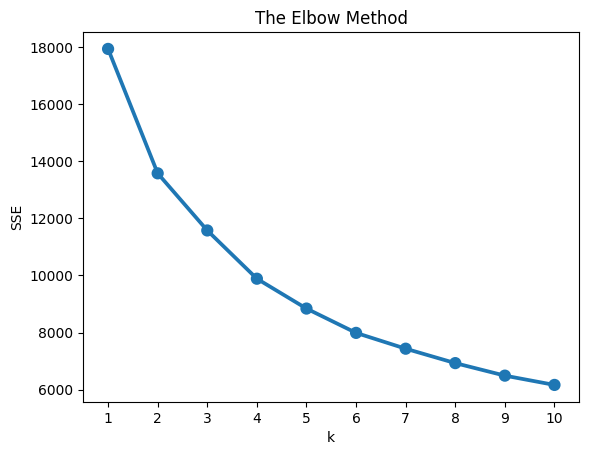

In [103]:
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [106]:
for i in [2,3, 4, 5]:
    name = 'Kmeans' + str(i)
    with mlflow.start_run(run_name=name):
        kmeans = KMeans(n_clusters= i, random_state = 1).fit(data_scaled)
        cluster_labels = kmeans.labels_
        mlflow.log_metric("silhouette_score", silhouette_score(data_scaled, cluster_labels))
        mlflow.log_param("n_clusters", i)
        mlflow.log_param("random_state", 1)
        mlflow.sklearn.log_model(kmeans, artifact_path= name, registered_model_name="kmeans")
        mlflow.end_run()
    
    


c:\Users\litle\repos\eclient_segmentation\eclientvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Successfully registered model 'kmeans'.
2023/04/08 22:12:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: kmeans, version 1
Created version '1' of model 'kmeans'.
c:\Users\litle\repos\eclient_segmentation\eclientvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Registered model 'kmeans' already exists. Creating a new version of this model...
2023/04/08 22:12:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.  

In [117]:
from sklearn.cluster import MeanShift
for i in [200, 400, 600, 800]:
    name = 'nameshift' + str(i)
    with mlflow.start_run(run_name=name):
        mean_shift = MeanShift(max_iter = i, n_jobs= - 1).fit(data_scaled)
        cluster_labels = mean_shift.labels_
        mlflow.log_metric("silhouette_score", silhouette_score(data_scaled, cluster_labels))
        mlflow.log_param("max_iter", i)
        mlflow.log_param("n_jobs", -1)
        mlflow.log_param("n_clusters", len(np.unique(cluster_labels)))
        mlflow.sklearn.log_model(mean_shift, artifact_path= name, registered_model_name="mean_shift")
        mlflow.end_run()

Successfully registered model 'mean_shift'.
2023/04/08 22:42:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mean_shift, version 1
Created version '1' of model 'mean_shift'.
Registered model 'mean_shift' already exists. Creating a new version of this model...
2023/04/08 22:43:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mean_shift, version 2
Created version '2' of model 'mean_shift'.
Registered model 'mean_shift' already exists. Creating a new version of this model...
2023/04/08 22:43:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mean_shift, version 3
Created version '3' of model 'mean_shift'.
Registered model 'mean_shift' already exists. Creating a new version of this model...
2023/04/08 22:44:10 

In [118]:
from sklearn.cluster import DBSCAN
max_distance = [0.1, 0.2, 0.3, 0.4]
min_samples = [2, 3, 4, 5]
for i in max_distance:
    for j in min_samples:
        name = 'DBSCAN' + str(i) + str(j)
        with mlflow.start_run(run_name=name):
            dbscan = DBSCAN(eps = i, min_samples = j).fit(data_scaled)
            cluster_labels = dbscan.labels_
            mlflow.log_metric("silhouette_score", silhouette_score(data_scaled, cluster_labels))
            mlflow.log_param("eps", i)
            mlflow.log_param("min_samples", j)
            mlflow.log_param("n_clusters", len(np.unique(cluster_labels)))
            mlflow.sklearn.log_model(dbscan, artifact_path= name, registered_model_name="dbscan")
            mlflow.end_run()
        
        



2023/04/08 22:50:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Successfully registered model 'dbscan'.
2023/04/08 22:50:39 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dbscan, version 1
Created version '1' of model 'dbscan'.
2023/04/08 22:50:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'dbscan' already exists. Creating a new version of this model...
2023/04/08 22:50:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: dbscan, version 2
Created version '2' of model 'dbscan'.
2023/04/08 22:50:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Registered model 'dbscan' already exists. Creating a new version of this model...
2023/04/0

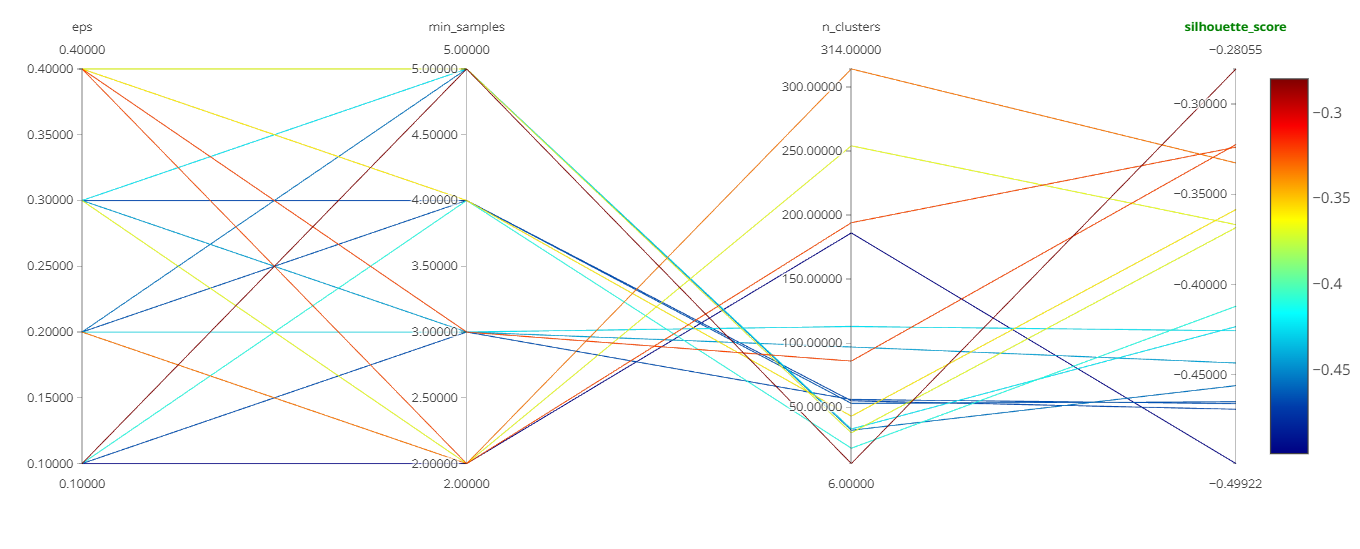

In [140]:
runs = mlflow.search_runs(experiment_names= ["Eclient segmentation"] ).sort_values("metrics.silhouette_score", ascending=False).head(5)
top_models = runs[['tags.mlflow.runName', 'metrics.silhouette_score', 'params.n_clusters']]


,tags.mlflow.runName,metrics.silhouette_score,params.n_clusters
23,Kmeans2,0.314767,2
16,nameshift800,0.310255,7
19,nameshift200,0.310255,7


In [171]:
from mlflow import pyfunc
model = pyfunc.load_model("runs:/a40b93c730c9458090bc5e25bd357419/Kmeans4")
clusters = model.predict(data_predict)
data['clusters'] = clusters

c:\Users\litle\repos\eclient_segmentation\eclientvenv\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [172]:
data.groupby('clusters').agg({'Recency': 'mean', 'Frequency': 'mean', 'MonetaryValue': ['mean', 'sum'], 'review_score': ['mean', 'count'], 'review_comment_message': ['mean', 'count'], 'payment_installments': ['mean', 'count']}).round(3)

Recency Frequency MonetaryValue            review_score        \
            mean      mean          mean        sum         mean count   
clusters                                                                 
2          5.321     0.683         5.208   3833.270        1.471   736   
3          5.450     0.860         5.608  12629.758        1.314  2252   

         review_comment_message       payment_installments        
                           mean count                 mean count  
clusters                                                          
2                         0.683   736                0.011   736  
3                         0.860  2252                1.147  2252

In [173]:
data_normalized = pd.DataFrame(data_scaled, index=RFM.index, columns=['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message'])


data_normalized['Cluster'] = data['clusters']

In [174]:
data_normalized.head(100)

,Recency,Frequency,MonetaryValue,payment_installments,review_score,review_comment_message,Cluster
customer_unique_id,,,,,,,
00172711b30d52eea8b313a7f2cced02,-1.947136,-0.427471,-0.016499,-0.582110,0.082943,-0.427471,3
004288347e5e88a27ded2bb23747066c,0.315690,-0.427471,0.496947,-0.219166,0.637325,-0.427471,3
004b45ec5c64187465168251cd1c9c2f,-0.702396,-0.427471,-0.708843,-1.093651,-0.631779,-0.427471,2
0058f300f57d7b93c477a131a59b36c3,-0.119448,0.975302,-0.470756,-1.093651,-0.133229,0.975302,3
00a39521eb40f7012db50455bf083460,-0.791842,-0.427471,-0.958406,-1.093651,0.082943,-0.427471,2
...,...,...,...,...,...,...,...
08a374bca4063116d5530a7b04ecaf3f,-1.947136,-0.427471,0.451085,1.811323,0.637325,-0.427471,3
08b57f87bc889756ca453bf8106d48ce,-1.040758,-0.427471,-1.015358,-1.093651,-0.248804,-0.427471,2
08c07c761592a71b85136aa4fe76a6f4,-0.235994,0.975302,0.681076,-0.024688,0.637325,0.975302,3


In [183]:
data_melt = pd.melt(data_normalized.reset_index(), id_vars=['customer_unique_id', 'Cluster'], value_vars=['Recency', 'Frequency', 'MonetaryValue', 'payment_installments', 'review_score', 'review_comment_message'], var_name='Attribute', value_name='Value')

In [185]:
data_melt.head()

,customer_unique_id,Cluster,Attribute,Value
0,00172711b30d52eea8b313a7f2cced02,3,Recency,-1.947136
1,004288347e5e88a27ded2bb23747066c,3,Recency,0.315690
2,004b45ec5c64187465168251cd1c9c2f,2,Recency,-0.702396
3,0058f300f57d7b93c477a131a59b36c3,3,Recency,-0.119448
4,00a39521eb40f7012db50455bf083460,2,Recency,-0.791842


In [177]:
data_melt_rfm_score = data_normalized.assign(General_Segment = data['General_Segment'])


data_melt_rfm_score = pd.melt(data_melt_rfm_score.reset_index(), id_vars=['customer_unique_id', 'General_Segment'], value_vars=['Recency', 'Frequency', 'MonetaryValue'], var_name='Attribute', value_name='Value')

data_melt_rfm_score.head()


,customer_unique_id,General_Segment,Attribute,Value
0,00172711b30d52eea8b313a7f2cced02,Silver,Recency,-1.947136
1,004288347e5e88a27ded2bb23747066c,Bronze,Recency,0.315690
2,004b45ec5c64187465168251cd1c9c2f,Bronze,Recency,-0.702396
3,0058f300f57d7b93c477a131a59b36c3,Gold,Recency,-0.119448
4,00a39521eb40f7012db50455bf083460,Bronze,Recency,-0.791842


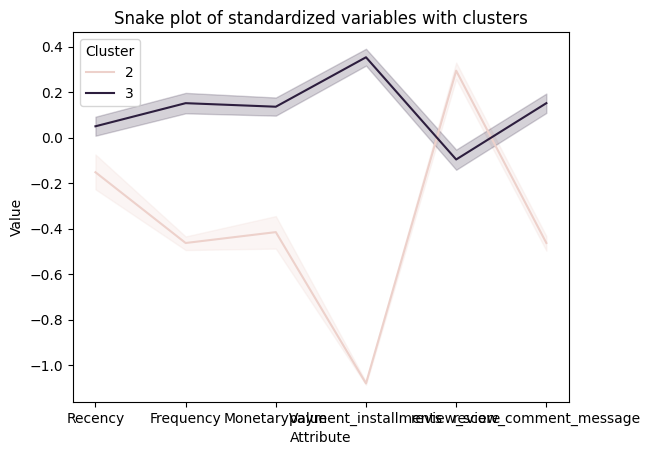

<Axes: title={'center': 'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

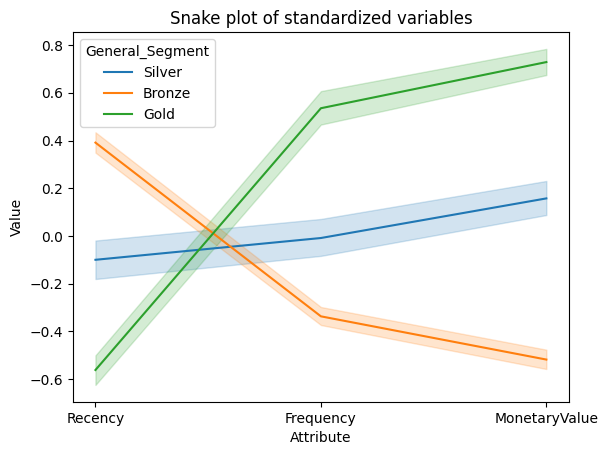

In [186]:
plt.title('Snake plot of standardized variables with clusters')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)
plt.show()
plt.title('Snake plot of standardized variables')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.lineplot(x="Attribute", y="Value", hue='General_Segment', data=data_melt_rfm_score)


In [356]:
data_segment = data_normalized.assign(General_Segment = data['General_Segment'])


In [358]:
cluster_avg = data_rfms_k4.groupby(['Cluster']).mean()
population_avg = data_rfms_k4.mean()
relative_imp_cluster = cluster_avg / population_avg - 1


segment_avg = data_segment.groupby(['General_Segment']).mean()

relative_imp_segment = segment_avg / population_avg - 1





In [359]:
relative_imp_cluster = relative_imp_cluster[['Recency', 'Frequency', 'MonetaryValue']]
relative_imp_cluster.round(2)
relative_imp_segment = relative_imp_segment[['Recency', 'Frequency', 'MonetaryValue']]
relative_imp_segment.round(2)

,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,-0.92,-1.29,-1.09
Gold,-1.12,-0.48,-0.88
Silver,-1.02,-1.10,-0.97


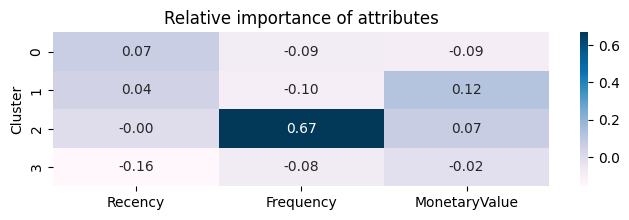

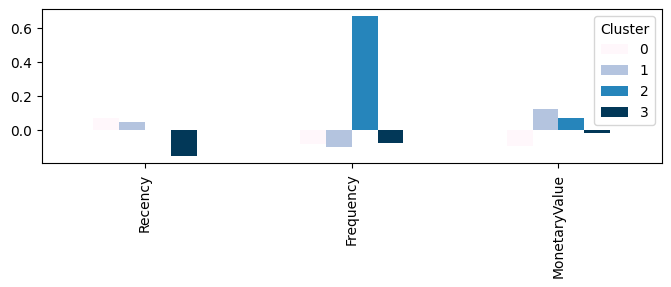

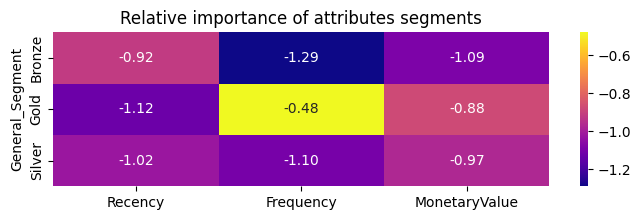

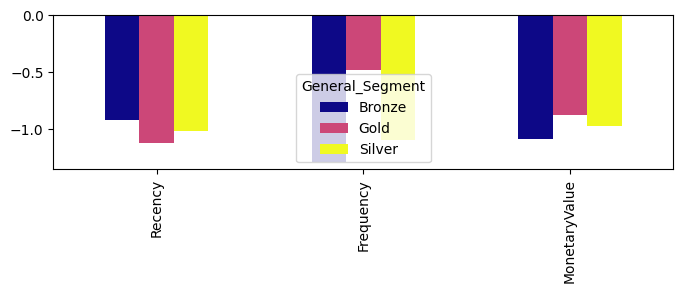

: 

In [361]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp_cluster, annot=True, fmt='.2f', cmap='PuBu')
plt.show()
relative_imp_cluster.T.plot(kind='bar', figsize=(8, 2), cmap='PuBu')
plt.show()
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes segments')
sns.heatmap(data=relative_imp_segment, annot=True, fmt='.2f', cmap='plasma')
plt.show()
relative_imp_segment.T.plot(kind='bar', figsize=(8, 2), cmap='plasma')
plt.show()
